# MTI under homo assumption

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
from obspy.imaging.beachball import beachball
from obspy.imaging.beachball import beach

from scipy.sparse.linalg import LinearOperator, cg, lsqr
from scipy.linalg import lstsq

from pylops.basicoperators import HStack, VStack
from pylops.utils import dottest
from pylops.utils.wavelets import *
from pylops.optimization.sparsity import *


In [2]:
from pyfrac.modelling.kirchhoff import Kirchhoff
from pyfrac.modelling.trueamp_kirchhoff import Kirchhoff as TAKirchhoff

from pyfrac.mtsolvers.homo_mti import collect_source_angles, pwave_zcomp_Greens, pwave_Greens_comp
from pyfrac.mtsolvers.mtutils import get_mt_computation_dict
from pyfrac.visualisation.eventimages import locimage3d

# 3D Model - Homo

In [3]:
# Velocity Model
nx, ny, nz = 47, 51, 75
dx, dy, dz = 4, 4, 4
x, y, z = np.arange(nx)*dx, np.arange(ny)*dy, np.arange(nz)*dz

v0 = 1000 # initial velocity
kv = 0. # gradient
vel = v0 * np.ones([nx, ny, nz])

(3, 143)
[[  4.  180.  162.4 144.8 127.2 109.6  92.   74.4  56.8  39.2  21.6   4.
  180.  162.4 144.8]
 [  4.    4.   20.   36.   52.   68.   84.  100.  116.  132.  148.  164.
  164.  180.  196. ]
 [  4.    4.    4.    4.    4.    4.    4.    4.    4.    4.    4.    4.
    4.    4.    4. ]]


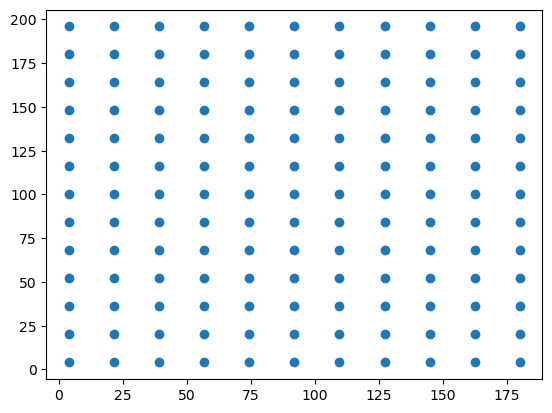

In [4]:
# RECEIVERS
#dr_xyz = 4*dx

grid_rx_locs = np.linspace(dx, (dx*nx)-2*dx, 11)
grid_ry_locs = np.linspace(dy, (dy*ny)-2*dy, 13)

rx, ry, rz = np.meshgrid(grid_rx_locs,
                         grid_ry_locs,
                         dz) 
recs = np.vstack((rx.flatten(), ry.flatten(), rz.flatten()))
nr = recs.shape[1]

plt.scatter(rx,ry)
print(recs.shape)
print(recs[:,::10])

In [5]:
grid_ry_locs, y.max(), grid_rx_locs, x.max()

(array([  4.,  20.,  36.,  52.,  68.,  84., 100., 116., 132., 148., 164.,
        180., 196.]),
 200,
 array([  4. ,  21.6,  39.2,  56.8,  74.4,  92. , 109.6, 127.2, 144.8,
        162.4, 180. ]),
 184)

## Get all necessary components

In [6]:
%%time

# TRAVEL TIME TABLE
trav = Kirchhoff._traveltime_table(z, 
                                   x, 
                                   y=y, 
                                   recs=recs,  
                                   vel=vel, 
                                   mode='eikonal')

TTT_full = trav.reshape(nx,ny,nz,nr).transpose([3,0,1,2])

CPU times: user 15.3 s, sys: 195 ms, total: 15.5 s
Wall time: 15.5 s


In [7]:
# AMPLITUDE TERMS
gamma_sourceangles, dist_table = collect_source_angles(x,y,z, reclocs=recs, nc=3)

In [8]:
# Source Parameters
omega_p = 30  # Assume central frequency of 25Hz
sloc_ind = [nx//2, ny//2, nz//2]  # As indices of velocity model

In [9]:
# Make cube area of interest as can't consider the full subsurface body
nx_aoi, ny_aoi, nz_aoi = 15, 13, 11
xsi, xfi = sloc_ind[0]-nx_aoi, sloc_ind[0]+nx_aoi+1   # start/end index of x-region of interest
ysi, yfi = sloc_ind[1]-ny_aoi, sloc_ind[1]+ny_aoi+1   # start/end index of y-region of interest
zsi, zfi = sloc_ind[2]-nz_aoi, sloc_ind[2]+nz_aoi+1   # start/end index of z-region of interest

In [10]:
# Parameters only for the area of interest
gamma_sourceangles_aoi = gamma_sourceangles[:, :, xsi:xfi, ysi:yfi, zsi:zfi]
dist_table_aoi = dist_table[:, xsi:xfi, ysi:yfi, zsi:zfi]
tt_table_aoi = TTT_full[:, xsi:xfi, ysi:yfi, zsi:zfi]

nr, nx_aoi, ny_aoi, nz_aoi = tt_table_aoi.shape
print(nr, nx_aoi, ny_aoi, nz_aoi)

143 31 27 23


In [11]:
MT_comp_dict = get_mt_computation_dict()  # This keeps everything nice and clean in the later G compute

## Compute Greens for specific source (location and frequency)

In [12]:
Gx_aoi = np.zeros([6, nr, nx_aoi, ny_aoi, nz_aoi]) 
Gy_aoi = np.zeros([6, nr, nx_aoi, ny_aoi, nz_aoi]) 
Gz_aoi = np.zeros([6, nr, nx_aoi, ny_aoi, nz_aoi]) 

for ix in range(nx_aoi):
    for iy in range(ny_aoi):
        for iz in range(nz_aoi):
            Gx_aoi[:,:,ix,iy,iz] = pwave_Greens_comp(gamma_sourceangles_aoi,
                                                      dist_table_aoi,
                                                      [ix,iy,iz],
                                                      1,
                                                      vel,
                                                      MT_comp_dict,
                                                      comp_gamma_ind=0)

            Gy_aoi[:,:,ix,iy,iz] = pwave_Greens_comp(gamma_sourceangles_aoi,
                                                      dist_table_aoi,
                                                      [ix,iy,iz],
                                                      1,
                                                      vel,
                                                      MT_comp_dict,
                                                      comp_gamma_ind=1)

            Gz_aoi[:,:,ix,iy,iz] = pwave_Greens_comp(gamma_sourceangles_aoi,
                                                      dist_table_aoi,
                                                      [ix,iy,iz],
                                                      1,
                                                      vel,
                                                      MT_comp_dict,
                                                      comp_gamma_ind=2)

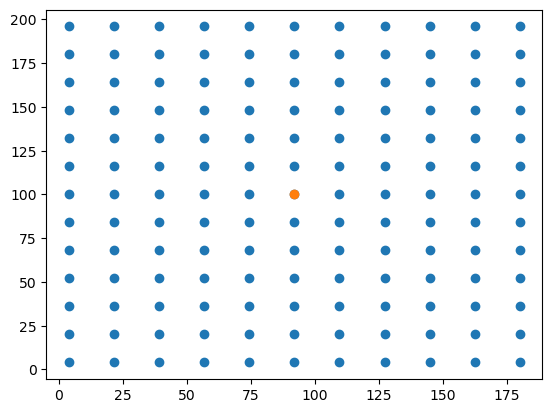

In [13]:
plt.scatter(rx,ry)
plt.scatter(recs[0, 71],recs[1, 71])

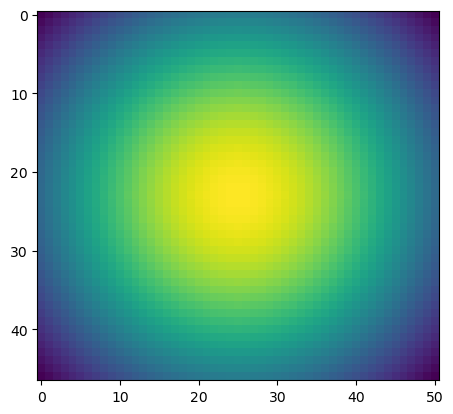

In [14]:
plt.imshow(gamma_sourceangles[2, 71, :, :, sloc_ind[2]])

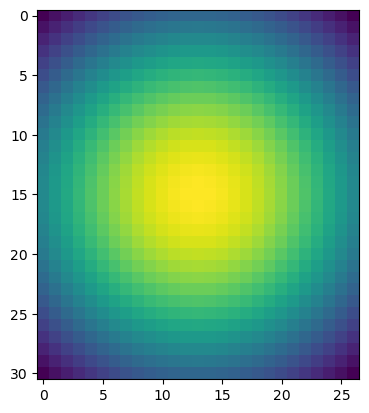

In [15]:
plt.imshow(Gz_aoi[2, 71, :, :, sloc_ind[2] - zsi])

# MT imaging with VZ

In [16]:
MT_aoi = np.zeros([6, nx_aoi, ny_aoi, nz_aoi])  # MT components as images

In [17]:
MT_selected =-1 * np.array([0,0,0,1,0,0]) #  np.array([1,1,1,0,0,0]) 

In [18]:
MT_aoi[:, nx_aoi//2, ny_aoi//2, nz_aoi//2] = MT_selected

In [19]:
nt = 251
dt = 0.004
t = np.arange(nt)*dt
wav, wavt, wavc = ricker(t[:41], f0=omega_p)

In [20]:
# Build 6 True Amp Kirchoff Operators
Ms_scaling = 1e6 # to avoid working with small numbers in inversion
Ms_Op = [TAKirchhoff(z=z[zsi:zfi],
                     x=x[xsi:xfi], 
                     y=y[ysi:yfi],
                     t=t,
                     srcs=recs[:, :1], 
                     recs=recs, 
                     wav=wav, 
                     wavcenter=wavc, 
                     wavfilter=True,
                     trav = tt_table_aoi.reshape(nr, -1).T,
                     amp = Ms_scaling * Gz_aoi[icomp].reshape(nr, -1).T.astype(np.float32),
                     engine='numba') 
         for icomp in range(6)]

# check operator with dottest
for icomp in range(6):
    _ = dottest(Ms_Op[icomp], verb=True, atol=1e-5)

Dot test passed, v^H(Opu)=-0.018793034217239754 - u^H(Op^Hv)=-0.01879303421723972
Dot test passed, v^H(Opu)=-0.004557050035382752 - u^H(Op^Hv)=-0.004557050035382782
Dot test passed, v^H(Opu)=-0.0773089747511827 - u^H(Op^Hv)=-0.07730897475118256
Dot test passed, v^H(Opu)=0.011437217881231337 - u^H(Op^Hv)=0.011437217881231344
Dot test passed, v^H(Opu)=-0.014505569308229929 - u^H(Op^Hv)=-0.014505569308229962
Dot test passed, v^H(Opu)=-0.0929224193810271 - u^H(Op^Hv)=-0.09292241938102708


In [21]:
Mstack_Op = HStack(Ms_Op, forceflat=True)

In [22]:
data = Mstack_Op @ MT_aoi.ravel()

MT_aoi_adj = Mstack_Op.H @ data.ravel()
MT_aoi_adj = MT_aoi_adj.reshape(MT_aoi.shape)

MT_aoi_inv = lsqr(Mstack_Op, data.ravel(), iter_lim=50, atol=0, btol=0, show=True)[0]
MT_aoi_inv = MT_aoi_inv.reshape(MT_aoi.shape)

data_inv = Mstack_Op @ MT_aoi_inv.ravel()

 
LSQR            Least-squares solution of  Ax = b
The matrix A has 35893 rows and 115506 columns
damp = 0.00000000000000e+00   calc_var =        0
atol = 0.00e+00                 conlim = 1.00e+08
btol = 0.00e+00               iter_lim =       50
 
   Itn      x[0]       r1norm     r2norm   Compatible    LS      Norm A   Cond A
     0  0.00000e+00   1.427e-04  1.427e-04    1.0e+00  1.0e+02
     1 -8.36191e-07   7.524e-05  7.524e-05    5.3e-01  5.9e-01   1.7e-02  1.0e+00
     2 -3.40291e-06   5.251e-05  5.251e-05    3.7e-01  3.5e-01   2.3e-02  2.2e+00
     3 -6.28507e-06   3.872e-05  3.872e-05    2.7e-01  2.4e-01   2.7e-02  3.7e+00
     4 -4.27258e-06   3.074e-05  3.074e-05    2.2e-01  1.8e-01   3.0e-02  5.3e+00
     5  7.96160e-07   2.593e-05  2.593e-05    1.8e-01  1.7e-01   3.2e-02  7.1e+00
     6  3.88857e-06   2.329e-05  2.329e-05    1.6e-01  1.4e-01   3.6e-02  8.9e+00
     7  5.91721e-06   2.101e-05  2.101e-05    1.5e-01  1.3e-01   3.9e-02  1.1e+01
     8  7.06712e-06   1.867e-05

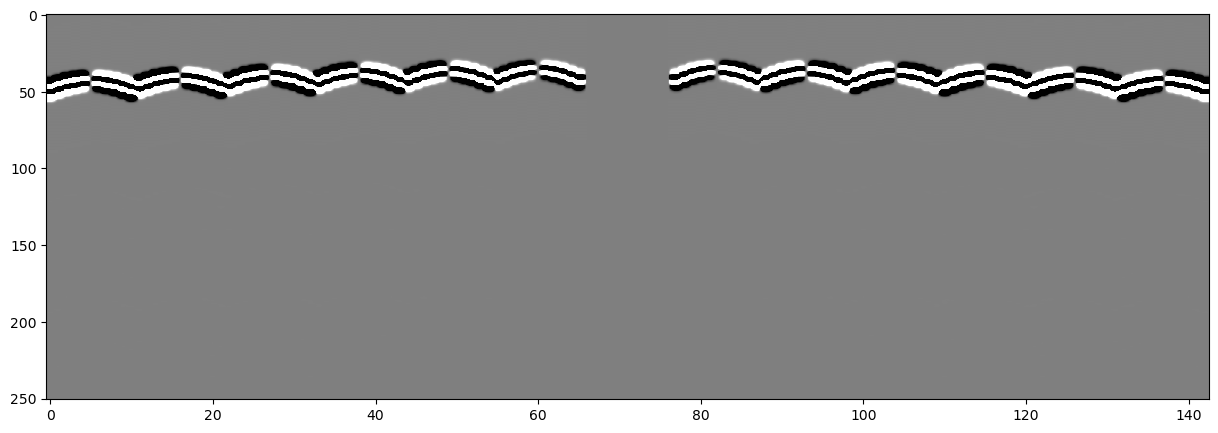

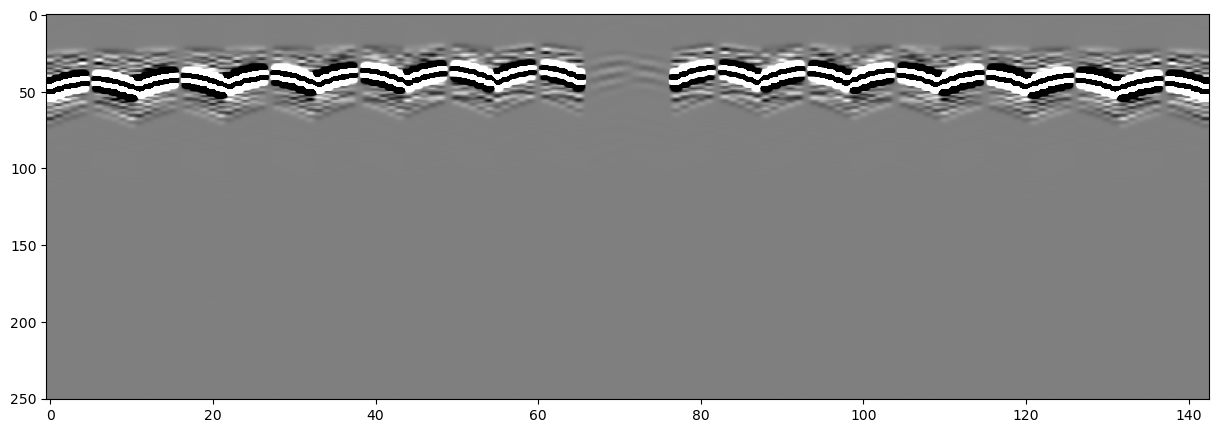

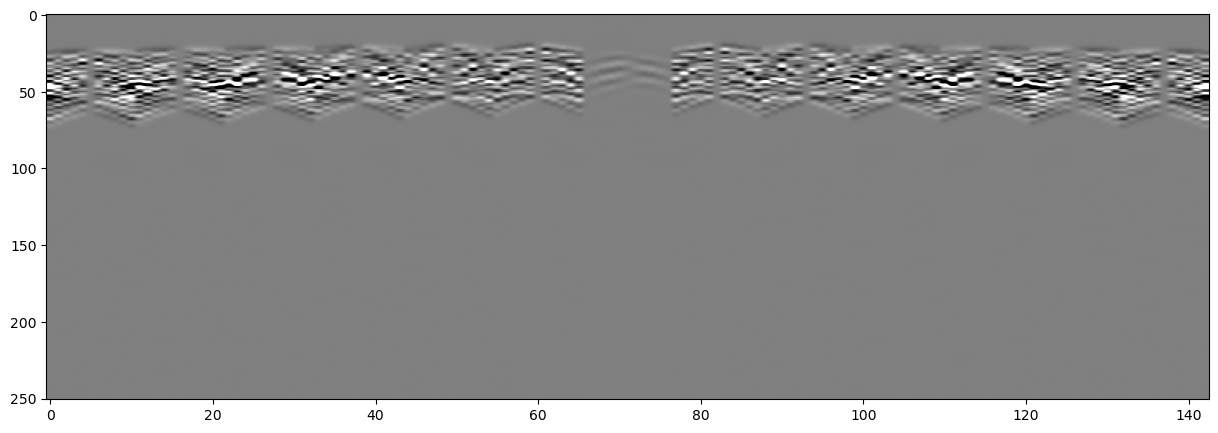

In [23]:
plt.figure(figsize=(15, 5))
plt.imshow(data.reshape(-1, nt).T, cmap='gray', vmin=-1e-7, vmax=1e-7)
plt.axis('tight');

plt.figure(figsize=(15, 5))
plt.imshow(data_inv.reshape(-1, nt).T, cmap='gray', vmin=-1e-7, vmax=1e-7)
plt.axis('tight')

plt.figure(figsize=(15, 5))
plt.imshow((data-data_inv).reshape(-1, nt).T, cmap='gray', vmin=-1e-7, vmax=1e-7)
plt.axis('tight');

In [24]:
MT_aoi_fista = fista(Mstack_Op, data.ravel(), np.zeros_like(MT_aoi).ravel(), niter=100, eps=1e-13, show=True)[0]
MT_aoi_fista = MT_aoi_fista.reshape(MT_aoi.shape)

data_fista = Mstack_Op @ MT_aoi_fista.ravel()

FISTA (soft thresholding)
--------------------------------------------------------------------------------
The Operator Op has 35893 rows and 115506 cols
eps = 1.000000e-13	tol = 1.000000e-10	niter = 100
alpha = 2.188874e+03	thresh = 1.094437e-10
--------------------------------------------------------------------------------
   Itn          x[0]              r2norm     r12norm     xupdate
     1      -5.3530e-07         3.782e-09   3.782e-09   4.540e-03
     2      -1.4066e-06         2.378e-09   2.378e-09   1.954e-03
     3      -2.4522e-06         1.623e-09   1.623e-09   1.605e-03
     4      -3.3844e-06         1.179e-09   1.179e-09   1.363e-03
     5      -3.9754e-06         8.929e-10   8.931e-10   1.196e-03
     6      -4.1088e-06         6.990e-10   6.992e-10   1.070e-03
     7      -3.7761e-06         5.632e-10   5.634e-10   9.658e-04
     8      -3.0473e-06         4.658e-10   4.660e-10   8.768e-04
     9      -2.0337e-06         3.938e-10   3.940e-10   8.007e-04
    10      -

(<Figure size 800x800 with 3 Axes>,
 (<Axes: xlabel='x samples', ylabel='t samples'>,
  <Axes: xlabel='y samples'>,
  <Axes: ylabel='y samples'>))

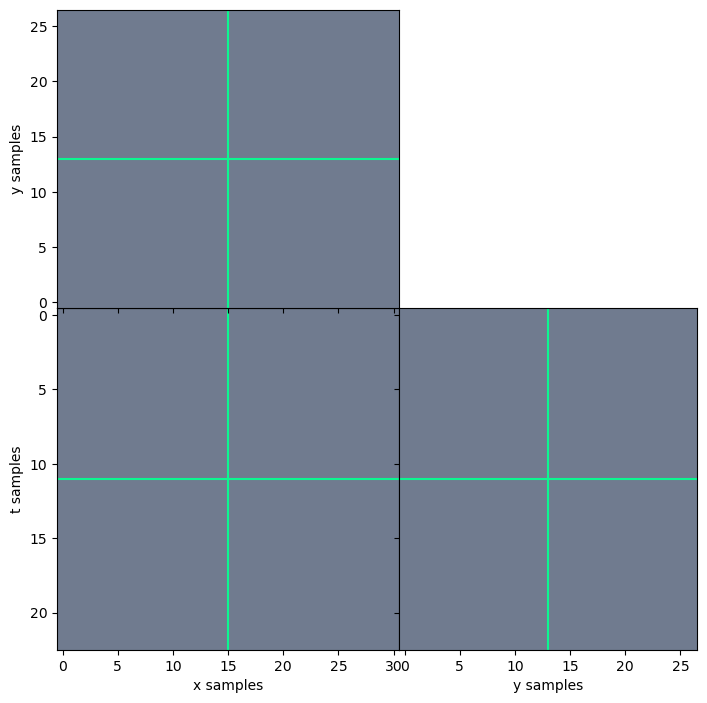

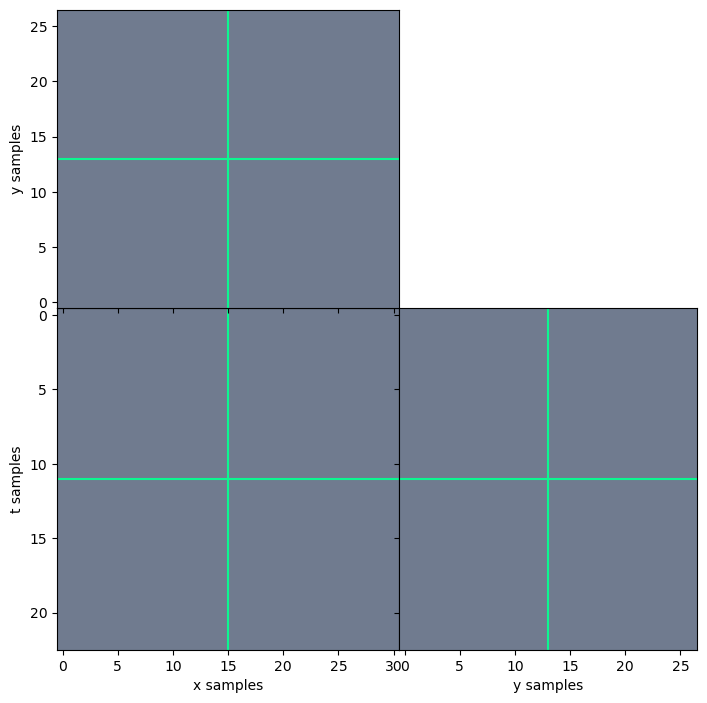

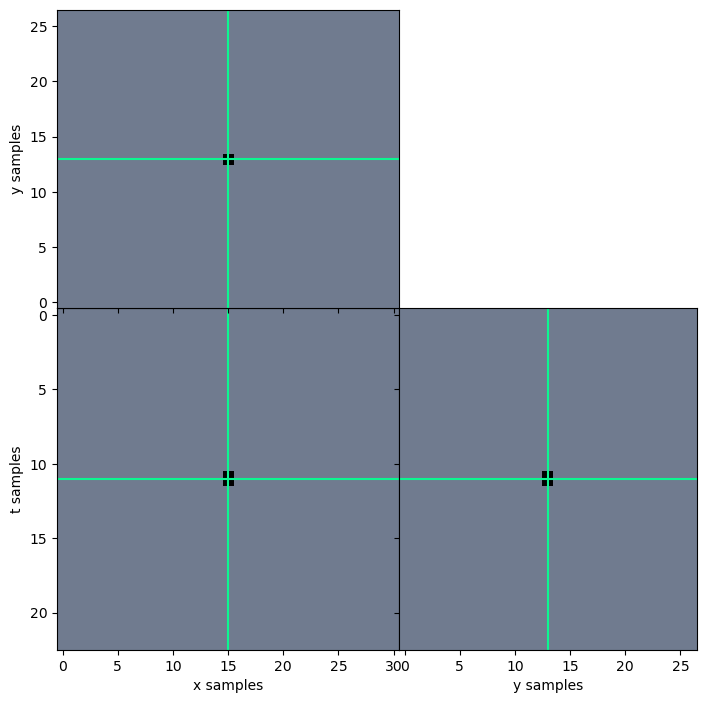

In [25]:
locimage3d(MT_aoi[0], sloc_ind[0]-xsi, sloc_ind[1]-ysi, clipval=[-1, 1])
locimage3d(MT_aoi[1], sloc_ind[0]-xsi, sloc_ind[1]-ysi, clipval=[-1, 1])
locimage3d(MT_aoi[3], sloc_ind[0]-xsi, sloc_ind[1]-ysi, clipval=[-1, 1])

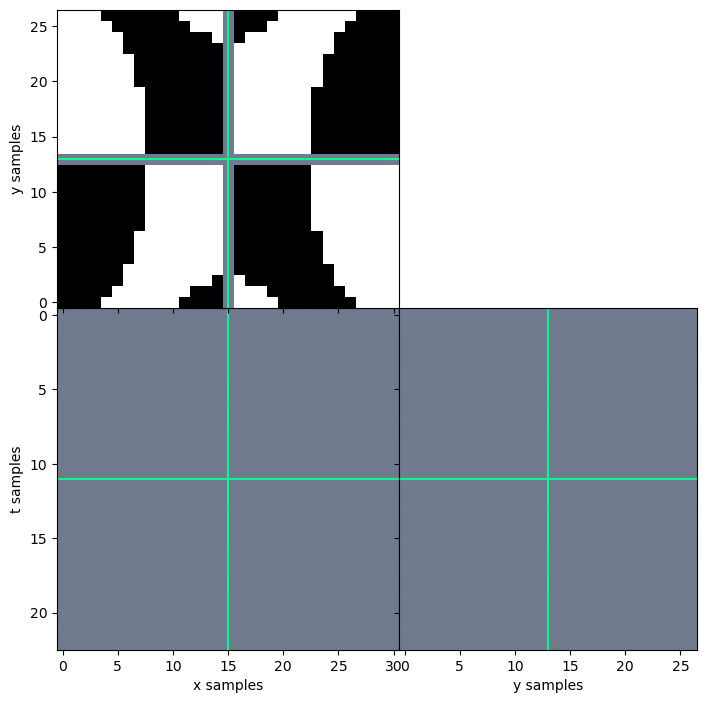

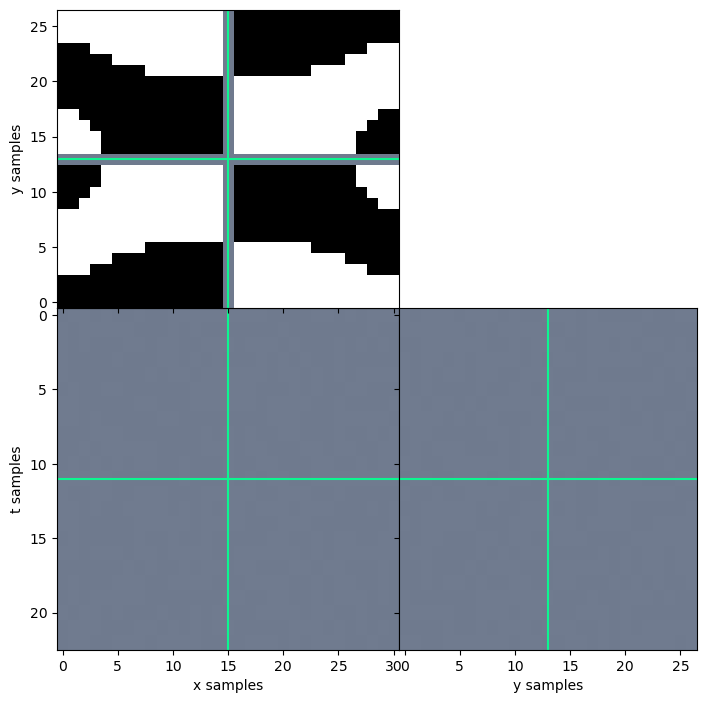

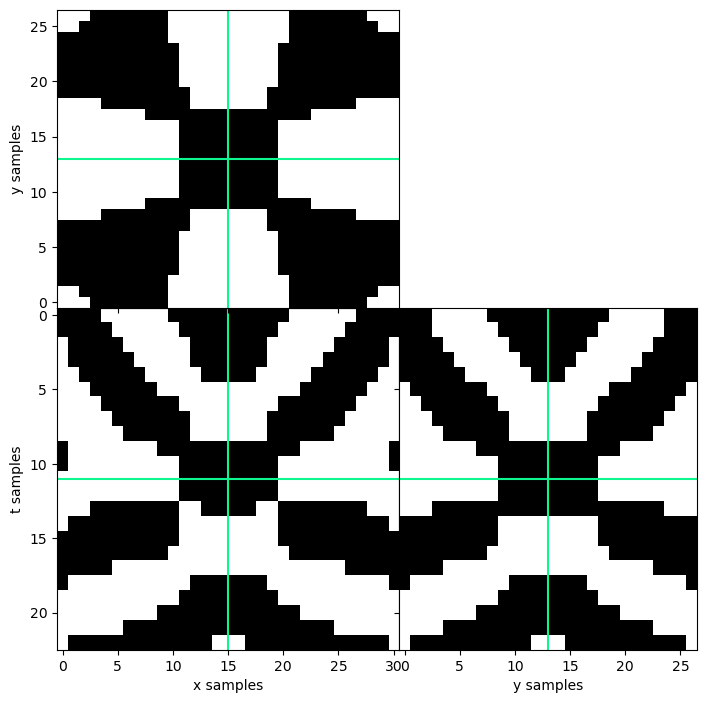

In [26]:
locimage3d(MT_aoi_adj[0], sloc_ind[0]-xsi, sloc_ind[1]-ysi, clipval=[-5e-13, 5e-13])
locimage3d(MT_aoi_adj[1], sloc_ind[0]-xsi, sloc_ind[1]-ysi, clipval=[-5e-13, 5e-13])
locimage3d(MT_aoi_adj[3], sloc_ind[0]-xsi, sloc_ind[1]-ysi, clipval=[-5e-13, 5e-13]);

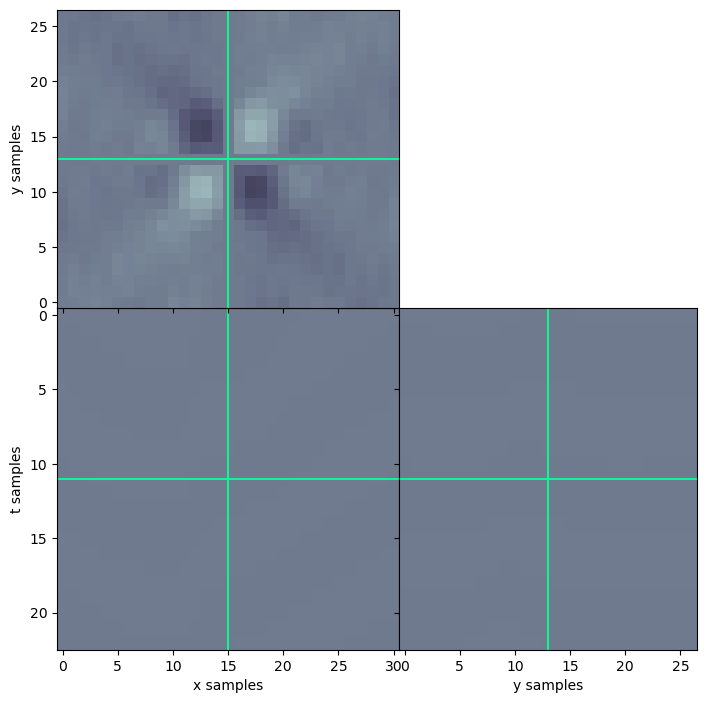

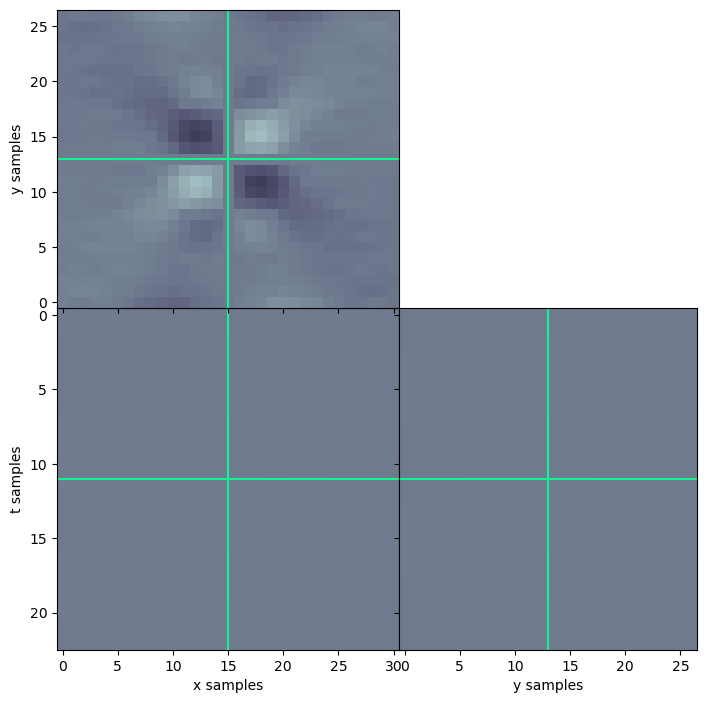

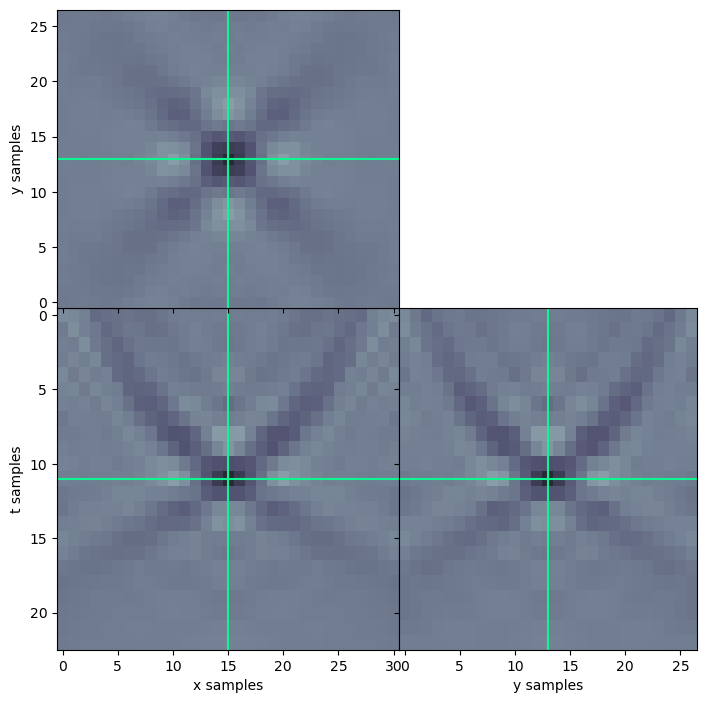

In [27]:
locimage3d(MT_aoi_inv[0], sloc_ind[0]-xsi, sloc_ind[1]-ysi, clipval=[-1e-3, 1e-3])
locimage3d(MT_aoi_inv[1], sloc_ind[0]-xsi, sloc_ind[1]-ysi, clipval=[-1e-3, 1e-3])
locimage3d(MT_aoi_inv[3], sloc_ind[0]-xsi, sloc_ind[1]-ysi, clipval=[-1e-3, 1e-3]);

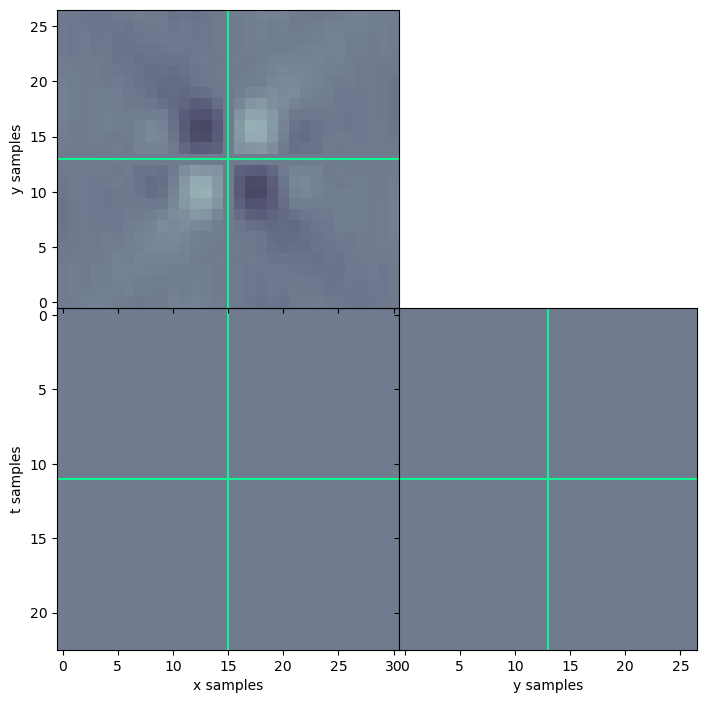

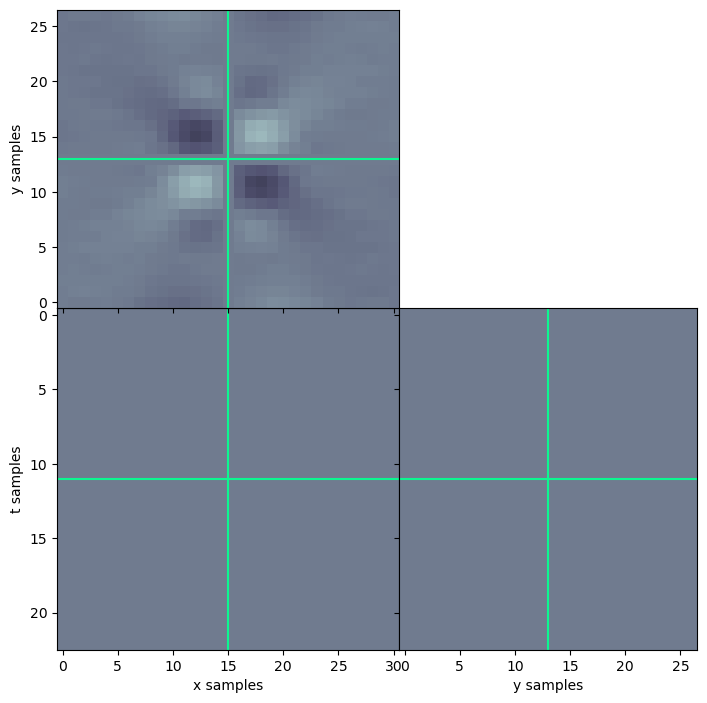

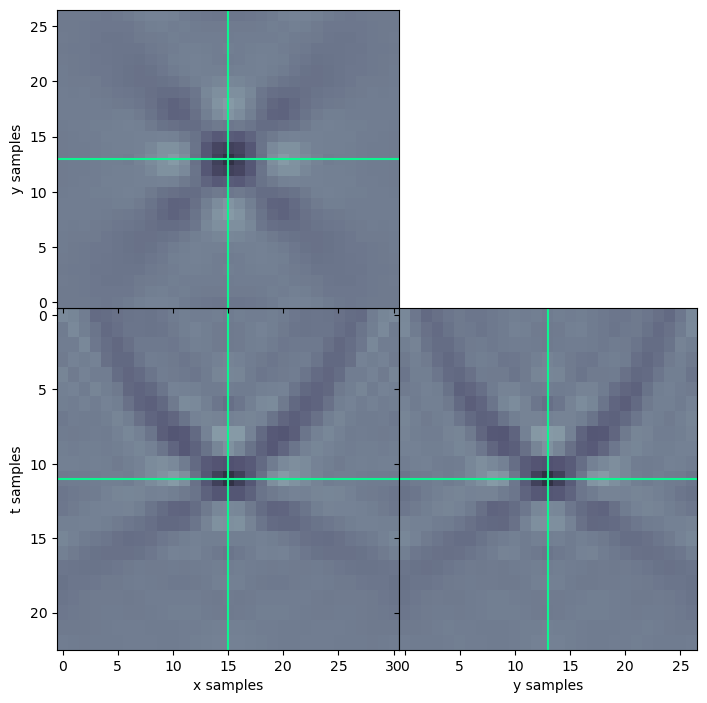

In [28]:
locimage3d(MT_aoi_fista[0], sloc_ind[0]-xsi, sloc_ind[1]-ysi, clipval=[-1e-3, 1e-3])
locimage3d(MT_aoi_fista[1], sloc_ind[0]-xsi, sloc_ind[1]-ysi, clipval=[-1e-3, 1e-3])
locimage3d(MT_aoi_fista[3], sloc_ind[0]-xsi, sloc_ind[1]-ysi, clipval=[-1e-3, 1e-3]);

## MT imaging with VX,VY,VZ

In [29]:
# Build 6 True Amp Kirchoff Operators
Ms_scaling = 1e6 # to avoid working with small numbers in inversion
Mx_Op = [TAKirchhoff(z=z[zsi:zfi],
                     x=x[xsi:xfi], 
                     y=y[ysi:yfi],
                     t=t,
                     srcs=recs[:, :1], 
                     recs=recs, 
                     wav=wav, 
                     wavcenter=wavc, 
                     wavfilter=True,
                     trav = tt_table_aoi.reshape(nr, -1).T,
                     amp = Ms_scaling * Gx_aoi[icomp].reshape(nr, -1).T.astype(np.float32),
                     engine='numba') 
         for icomp in range(6)]

My_Op = [TAKirchhoff(z=z[zsi:zfi],
                     x=x[xsi:xfi], 
                     y=y[ysi:yfi],
                     t=t,
                     srcs=recs[:, :1], 
                     recs=recs, 
                     wav=wav, 
                     wavcenter=wavc, 
                     wavfilter=True,
                     trav = tt_table_aoi.reshape(nr, -1).T,
                     amp = Ms_scaling * Gy_aoi[icomp].reshape(nr, -1).T.astype(np.float32),
                     engine='numba') 
         for icomp in range(6)]

Mz_Op = [TAKirchhoff(z=z[zsi:zfi],
                     x=x[xsi:xfi], 
                     y=y[ysi:yfi],
                     t=t,
                     srcs=recs[:, :1], 
                     recs=recs, 
                     wav=wav, 
                     wavcenter=wavc, 
                     wavfilter=True,
                     trav = tt_table_aoi.reshape(nr, -1).T,
                     amp = Ms_scaling * Gz_aoi[icomp].reshape(nr, -1).T.astype(np.float32),
                     engine='numba') 
         for icomp in range(6)]

Mxstack_Op = HStack(Mx_Op, forceflat=True)
Mystack_Op = HStack(My_Op, forceflat=True)
Mzstack_Op = HStack(Mz_Op, forceflat=True)

Mstack_Op = VStack([Mxstack_Op, Mystack_Op, Mzstack_Op])

# check operator with dottest
_ = dottest(Mstack_Op, verb=True, atol=1e-5)

Dot test passed, v^H(Opu)=0.1300697222779538 - u^H(Op^Hv)=0.13006972227795352


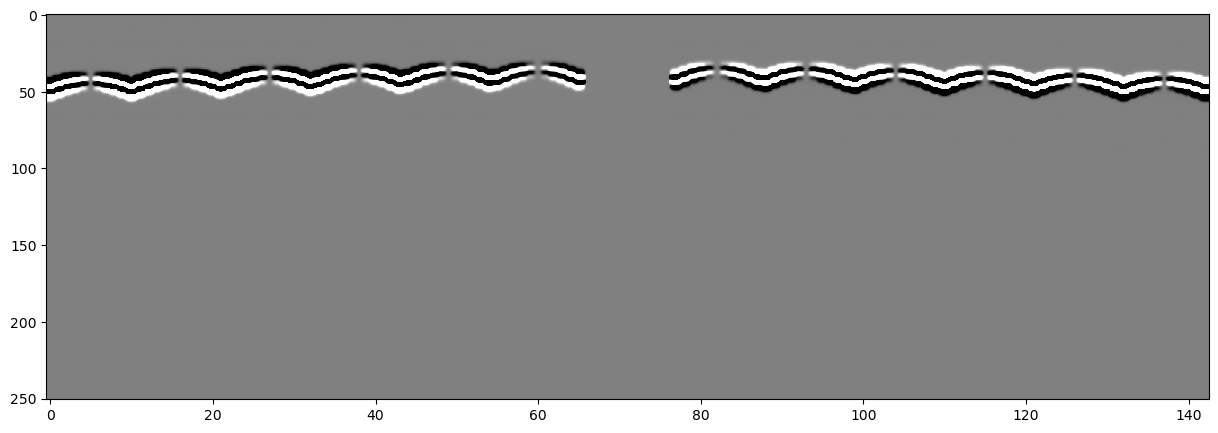

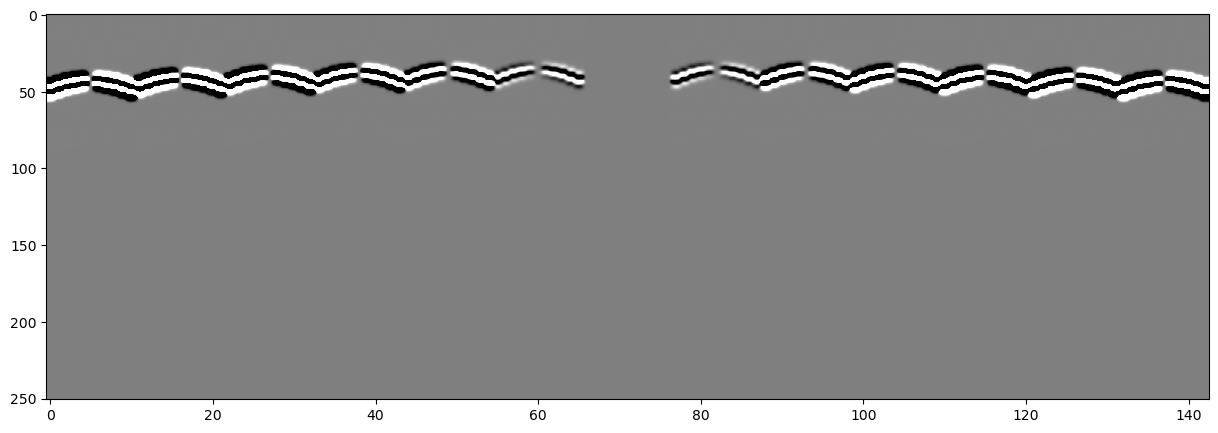

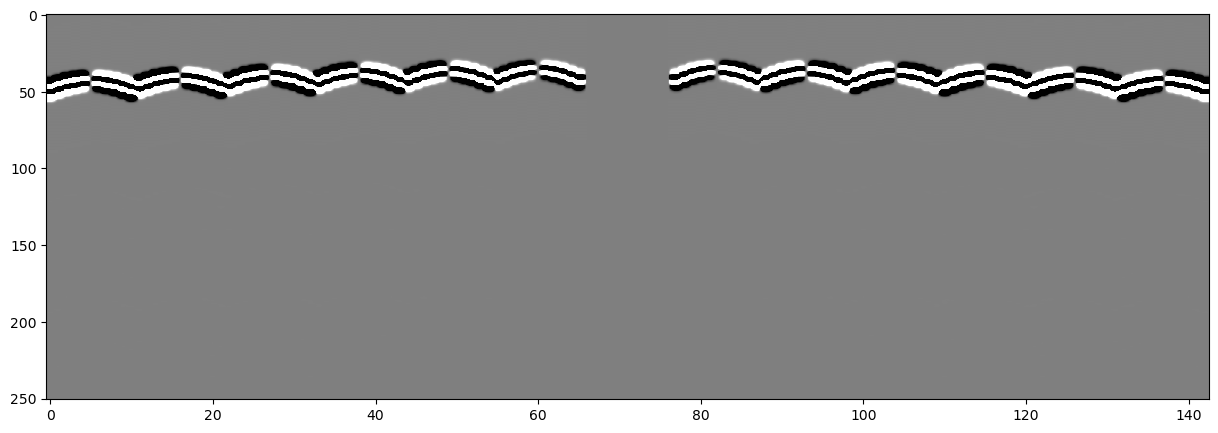

In [30]:
data = Mstack_Op @ MT_aoi.ravel()

data = data.reshape(3, nr, nt)

plt.figure(figsize=(15, 5))
plt.imshow(data[0].reshape(-1, nt).T, cmap='gray', vmin=-1e-7, vmax=1e-7)
plt.axis('tight')

plt.figure(figsize=(15, 5))
plt.imshow(data[1].reshape(-1, nt).T, cmap='gray', vmin=-1e-7, vmax=1e-7)
plt.axis('tight')

plt.figure(figsize=(15, 5))
plt.imshow(data[2].reshape(-1, nt).T, cmap='gray', vmin=-1e-7, vmax=1e-7)
plt.axis('tight');


In [31]:
data = Mstack_Op @ MT_aoi.ravel()

MT_aoi_adj = Mstack_Op.H @ data.ravel()
MT_aoi_adj = MT_aoi_adj.reshape(MT_aoi.shape)

MT_aoi_inv = lsqr(Mstack_Op, data.ravel(), iter_lim=50, atol=0, btol=0, show=True)[0]
MT_aoi_inv = MT_aoi_inv.reshape(MT_aoi.shape)

data_inv = Mstack_Op @ MT_aoi_inv.ravel()

 
LSQR            Least-squares solution of  Ax = b
The matrix A has 107679 rows and 115506 columns
damp = 0.00000000000000e+00   calc_var =        0
atol = 0.00e+00                 conlim = 1.00e+08
btol = 0.00e+00               iter_lim =       50
 
   Itn      x[0]       r1norm     r2norm   Compatible    LS      Norm A   Cond A
     0  0.00000e+00   1.738e-04  1.738e-04    1.0e+00  9.8e+01
     1 -2.18482e-06   8.795e-05  8.795e-05    5.1e-01  5.5e-01   2.0e-02  1.0e+00
     2 -5.02460e-06   6.194e-05  6.194e-05    3.6e-01  3.3e-01   2.6e-02  2.2e+00
     3 -1.51960e-06   4.837e-05  4.837e-05    2.8e-01  2.2e-01   3.0e-02  3.7e+00
     4  4.09412e-06   4.052e-05  4.052e-05    2.3e-01  1.6e-01   3.4e-02  5.3e+00
     5  5.05272e-06   3.620e-05  3.620e-05    2.1e-01  1.3e-01   3.7e-02  7.0e+00
     6  5.73908e-06   3.281e-05  3.281e-05    1.9e-01  1.1e-01   3.9e-02  9.1e+00
     7  3.50211e-06   3.027e-05  3.027e-05    1.7e-01  9.6e-02   4.2e-02  1.1e+01
     8 -1.10058e-06   2.835e-0

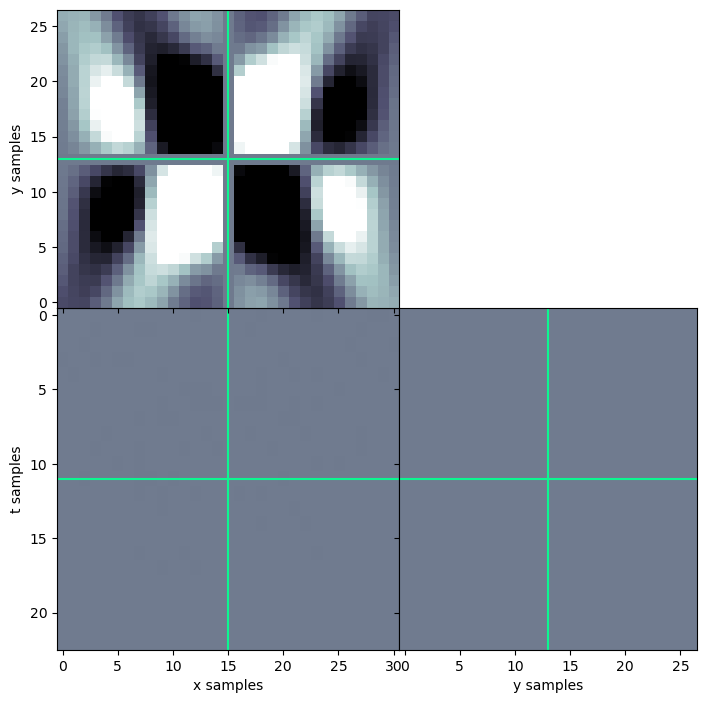

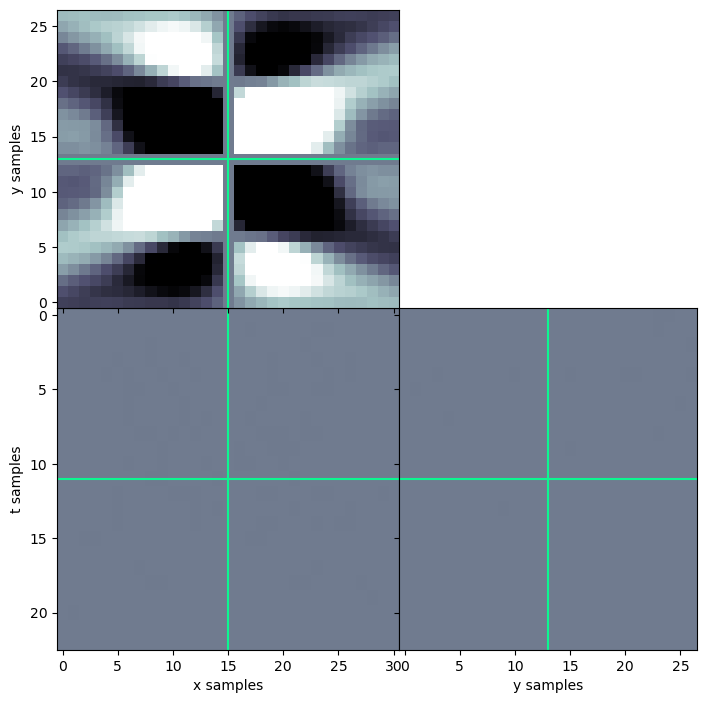

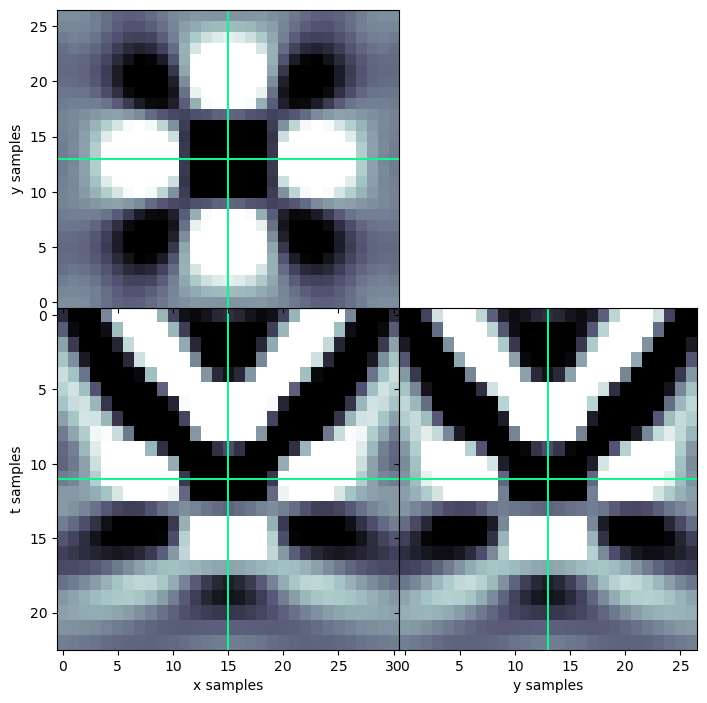

In [32]:
locimage3d(MT_aoi_adj[0], sloc_ind[0]-xsi, sloc_ind[1]-ysi, clipval=[-5e-9, 5e-9])
locimage3d(MT_aoi_adj[1], sloc_ind[0]-xsi, sloc_ind[1]-ysi, clipval=[-5e-9, 5e-9])
locimage3d(MT_aoi_adj[3], sloc_ind[0]-xsi, sloc_ind[1]-ysi, clipval=[-5e-9, 5e-9]);

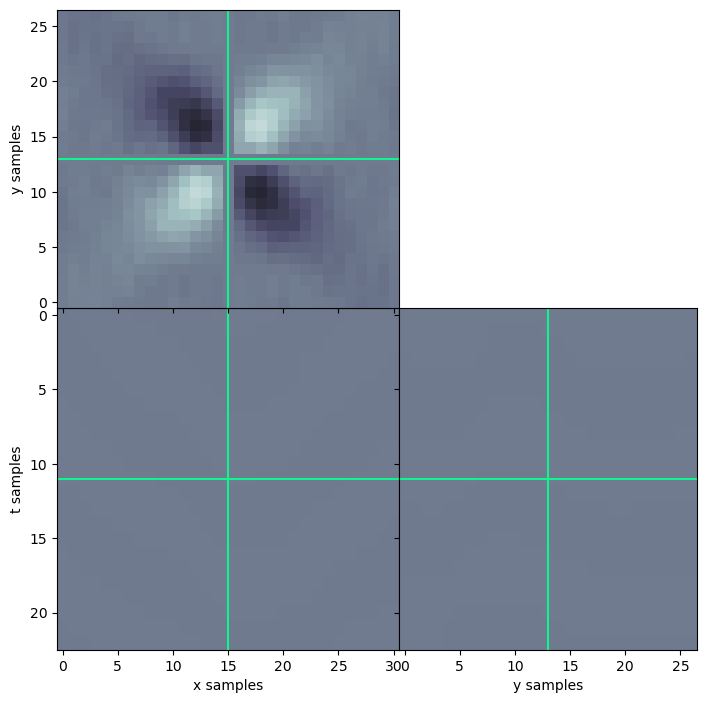

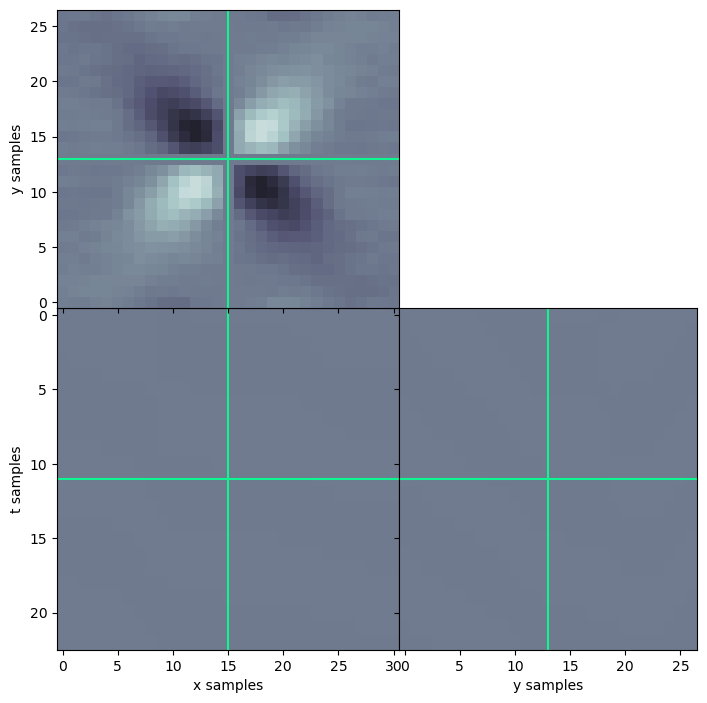

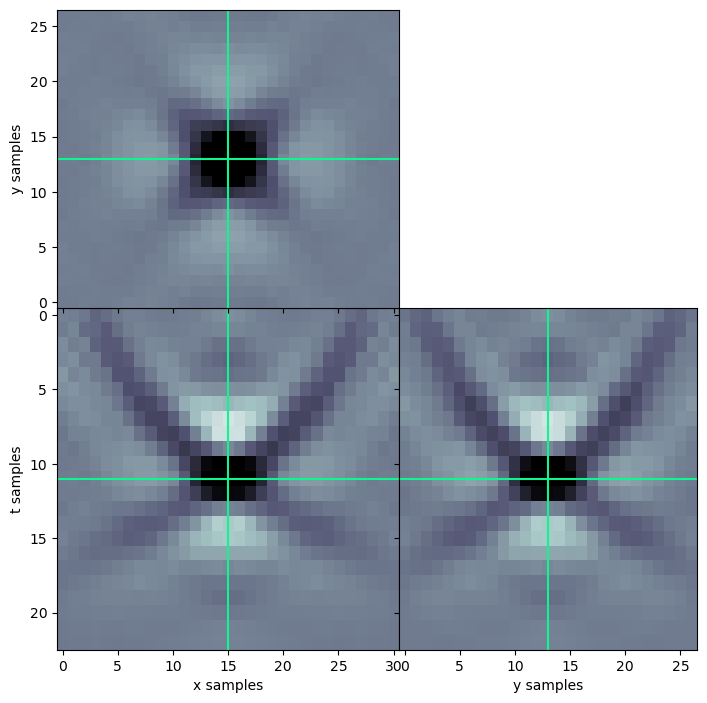

In [33]:
locimage3d(MT_aoi_inv[0], sloc_ind[0]-xsi, sloc_ind[1]-ysi, clipval=[-1e-3, 1e-3])
locimage3d(MT_aoi_inv[1], sloc_ind[0]-xsi, sloc_ind[1]-ysi, clipval=[-1e-3, 1e-3])
locimage3d(MT_aoi_inv[3], sloc_ind[0]-xsi, sloc_ind[1]-ysi, clipval=[-1e-3, 1e-3]);